# Assignment 2: Text Classification with Various Neural Networks

**Description:** This assignment covers various neural network architectures and components, largely used in the context of classification. You will compare Deep Averaging Networks, Deep Weighted Averaging Networks using Attention, and BERT-based models. You should also be able to develop an intuition for:


*   The effects of fine-tuning word vectors or starting with random word vectors
*   How various networks behave when the training set size changes
*   The effect of shuffling your training data
*   The benefits of Attention calculations
*   Working with BERT


The assignment notebook closely follows the lesson notebooks. We will use the IMDB dataset and will leverage some of the models, or part of the code, for our current investigation.

The initial part of the notebook is purely setup. We will then evaluate how Attention can make Deep Averaging networks better.

Do not try to run this entire notebook on your GCP instance as the training of models requires a GPU to work in a timely fashion. This notebook should be run on a Google Colab leveraging a GPU. By default, when you open the notebook in Colab it will try to use a GPU. Total runtime of the entire notebook (with solutions and a Colab GPU) should be about 1h.


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/datasci-w266/2024-spring-main/blob/master/assignment/a2/Text_classification.ipynb)

The overall assignment structure is as follows:


1. Setup
  
  1.1 Libraries, Embeddings,  & Helper Functions

  1.2 Data Acquisition

  1.3. Data Preparation

      1.3.1 Training/Test Sets using Word2Vec

      1.3.2 Training/Test Sets for BERT-based models


2. Classification with various Word2Vec-based Models

  2.1 The Role of Shuffling of the Training Set

  2.2 DAN vs Weighted Averaging Models using Attention

    2.2.1 Warm-Up
    
    2.2.2 The WAN Model
    
  2.3 Approaches for Training of Embeddings


3. Classification with BERT

  3.1. BERT Basics

  3.2 CLS-Token-based Classification

  3.3 Averaging of BERT Outputs

  3.4. Adding a CNN on top of BERT



**INSTRUCTIONS:**:

* Questions are always indicated as **QUESTION**, so you can search for this string to make sure you answered all of the questions. You are expected to fill out, run, and submit this notebook, as well as to answer the questions in the **answers** file as you did in a1.  Please do **not** remove the output from your notebooks when you submit them as we'll look at the output as well as your code for grading purposes.

* **### YOUR CODE HERE** indicates that you are supposed to write code.

* If you want to, you can run all of the cells in section 1 in bulk. This is setup work and no questions are in there. At the end of section 1 we will state all of the relevant variables that were defined and created in section 1.

* Finally, unless otherwise indicated your validation accuracy will be 0.65 or higher if you have correctly implemented the model.



## 1. Setup

### 1.1. Libraries and Helper Functions

This notebook requires the TensorFlow dataset and other prerequisites that you must download.

In [1]:
#@title Installs

!pip install pydot --quiet
!pip install gensim --quiet
!pip install tensorflow-datasets --quiet
!pip install -U tensorflow-text --quiet
!pip install transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 17.6 MB/s eta 0:00:00


Now we are ready to do the imports.

In [2]:
#@title Imports

import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

from transformers import BertTokenizer, TFBertModel
from transformers import logging
logging.set_verbosity_error()

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt

import re

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

Below is a helper function to plot histories.

In [3]:
#@title Plotting Function

# 4-window plot. Small modification from matplotlib examples.

def make_plot(axs,
              model_history1,
              model_history2,
              model_1_name='model 1',
              model_2_name='model 2',
              ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy']):
        # small adjustment to account for the 2 accuracy measures in the Weighted Averging Model with Attention
        if 'classification_%s' % metric in model_history2.history:
            metric2 = 'classification_%s' % metric
        else:
            metric2 = metric

        y_lim_lower1 = np.min(model_history1.history[metric])
        y_lim_lower2 = np.min(model_history2.history[metric2])
        y_lim_lower = min(y_lim_lower1, y_lim_lower2) * 0.9

        y_lim_upper1 = np.max(model_history1.history[metric])
        y_lim_upper2 = np.max(model_history2.history[metric2])
        y_lim_upper = max(y_lim_upper1, y_lim_upper2) * 1.1

        for j, model_history in enumerate([model_history1, model_history2]):
            model_name = [model_1_name, model_2_name][j]
            model_metric = [metric, metric2][j]
            ax1 = axs[i, j]
            ax1.plot(model_history.history[model_metric])
            ax1.plot(model_history.history['val_%s' % model_metric])
            ax1.set_title('%s - %s' % (metric, model_name))
            ax1.set_ylabel(metric, bbox=box)
            ax1.set_ylim(y_lim_lower, y_lim_upper)

Next, we get the word2vec model from nltk.

In [4]:
#@title NLTK & Word2Vec

nltk.download('word2vec_sample')

word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))

wvmodel = KeyedVectors.load_word2vec_format(datapath(word2vec_sample), binary=False)

[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Unzipping models/word2vec_sample.zip.


Now here we have the embedding **model** defined, let's see how many words are in the vocabulary:

In [5]:
len(wvmodel)

43981

What do the word vectors look like? As expected:

In [6]:
wvmodel['great'][:20]

array([ 0.0306035 ,  0.0886877 , -0.0121269 ,  0.0761965 ,  0.0566269 ,
       -0.0424702 ,  0.0410129 , -0.0497567 , -0.00364328,  0.0632889 ,
       -0.0142608 , -0.0791111 ,  0.0174877 , -0.0383064 ,  0.00926433,
        0.0295626 ,  0.0770293 ,  0.0949334 , -0.0428866 , -0.0295626 ],
      dtype=float32)

We can now build the embedding matrix and a vocabulary dictionary:

In [7]:
EMBEDDING_DIM = len(wvmodel['university'])      # we know... it's 300

# initialize embedding matrix and word-to-id map:
embedding_matrix = np.zeros((len(wvmodel) + 1, EMBEDDING_DIM))
vocab_dict = {}

# build the embedding matrix and the word-to-id map:
for i, word in enumerate(wvmodel.index_to_key):
    embedding_vector = wvmodel[word]

    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        vocab_dict[word] = i

# we can use the last index at the end of the vocab for unknown tokens
vocab_dict['[UNK]'] = len(vocab_dict)

In [8]:
embedding_matrix.shape

(43982, 300)

In [9]:
embedding_matrix[:5, :5]

array([[ 0.0891758 ,  0.121832  , -0.0671959 ,  0.0477279 , -0.013659  ],
       [ 0.0526281 ,  0.013157  , -0.010104  ,  0.0540819 ,  0.0386715 ],
       [ 0.0786419 ,  0.0373911 , -0.0131472 ,  0.0347375 ,  0.0288273 ],
       [-0.00157585, -0.0564239 ,  0.00320281,  0.0422498 ,  0.15264399],
       [ 0.0356899 , -0.00367283, -0.065534  ,  0.0213832 ,  0.00788408]])

The last row consists of all zeros. We will use that for the UNK token, the placeholder token for unknown words.

### 1.2 Data Acquisition


We will use the IMDB dataset delivered as part of the TensorFlow-datasets library, and split into training and test sets. For expedience, we will limit ourselves in terms of train and test examples.

In [10]:
train_data, test_data = tfds.load(
    name="imdb_reviews",
    split=('train[:80%]', 'test[80%:]'),
    as_supervised=True)

train_examples, train_labels = next(iter(train_data.batch(20000)))
test_examples, test_labels = next(iter(test_data.batch(5000)))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteAKDT7L/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteAKDT7L/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteAKDT7L/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


It is always highly recommended to look at the data. What do the records look like? Are they clean or do they contain a lot of cruft (potential noise)?

In [11]:
train_examples[:4]

<tf.Tensor: shape=(4,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell a

In [12]:
train_labels[:4]

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 0, 0, 1])>

For convenience, in this assignment we will define a sequence length and truncate all records at that length. For records that are shorter than our defined sequence length we will add padding characters to insure that our input shapes are consistent across all records.

In [13]:
MAX_SEQUENCE_LENGTH = 100

## 1.3. Data Preparation

### 1.3.1. Training/Test Sets for Word2Vec-based Models

First, we tokenize the data:

In [14]:
tokenizer = tf_text.WhitespaceTokenizer()
train_tokens = tokenizer.tokenize(train_examples)
test_tokens = tokenizer.tokenize(test_examples)

Let's look at some tokens.  Does they look acceptable?

In [15]:
train_tokens[0]

<tf.Tensor: shape=(116,), dtype=string, numpy=
array([b'This', b'was', b'an', b'absolutely', b'terrible', b'movie.',
       b"Don't", b'be', b'lured', b'in', b'by', b'Christopher', b'Walken',
       b'or', b'Michael', b'Ironside.', b'Both', b'are', b'great',
       b'actors,', b'but', b'this', b'must', b'simply', b'be', b'their',
       b'worst', b'role', b'in', b'history.', b'Even', b'their', b'great',
       b'acting', b'could', b'not', b'redeem', b'this', b"movie's",
       b'ridiculous', b'storyline.', b'This', b'movie', b'is', b'an',
       b'early', b'nineties', b'US', b'propaganda', b'piece.', b'The',
       b'most', b'pathetic', b'scenes', b'were', b'those', b'when',
       b'the', b'Columbian', b'rebels', b'were', b'making', b'their',
       b'cases', b'for', b'revolutions.', b'Maria', b'Conchita',
       b'Alonso', b'appeared', b'phony,', b'and', b'her', b'pseudo-love',
       b'affair', b'with', b'Walken', b'was', b'nothing', b'but', b'a',
       b'pathetic', b'emotional', b

Yup... looks right. Of course we will need to take care of the encoding later.

Next, we define a simple function that converts the tokens above into the appropriate word2vec index values.   

In [16]:
def docs_to_vocab_ids(tokenized_texts_list):
    """
    converting a list of strings to a list of lists of word ids
    """
    texts_vocab_ids = []
    text_labels = []
    valid_example_list = []
    for i, token_list in enumerate(tokenized_texts_list):

        # Get the vocab id for each token in this doc ([UNK] if not in vocab)
        vocab_ids = []
        for token in list(token_list.numpy()):
            decoded = token.decode('utf-8', errors='ignore')
            if decoded in vocab_dict:
                vocab_ids.append(vocab_dict[decoded])
            else:
                vocab_ids.append(vocab_dict['[UNK]'])

        # Truncate text to max length, add padding up to max length
        vocab_ids = vocab_ids[:MAX_SEQUENCE_LENGTH]
        n_padding = (MAX_SEQUENCE_LENGTH - len(vocab_ids))
        # For simplicity in this model, we'll just pad with unknown tokens
        vocab_ids += [vocab_dict['[UNK]']] * n_padding
        # Add this example to the list of converted docs
        texts_vocab_ids.append(vocab_ids)

        if i % 5000 == 0:
            print('Examples processed: ', i)

    print('Total examples: ', i)
    return np.array(texts_vocab_ids)

Now we can create training and test data that can be fed into the models of interest.  We need to convert all of the tokens in to their respective input ids.

In [17]:
train_input_ids = docs_to_vocab_ids(train_tokens)
test_input_ids = docs_to_vocab_ids(test_tokens)

train_input_labels = np.array(train_labels)
test_input_labels = np.array(test_labels)

Examples processed:  0
Examples processed:  5000
Examples processed:  10000
Examples processed:  15000
Total examples:  19999
Examples processed:  0
Total examples:  4999


Let's convince ourselves that the data looks correct:

In [18]:
train_input_ids[:2]

array([[21531, 25272, 12291,  7427, 37254, 43981,  6891, 12917, 38232,
        16915, 12929, 16182, 43981, 20526, 23487, 43981, 23807, 42958,
        35058, 43981, 19123, 35029, 41270, 29275, 12917, 32597, 20659,
          638, 16915, 43981,   174, 32597, 35058, 39971,  2326,  3636,
        22434, 35029, 43981, 33922, 43981, 21531, 34710, 16908, 12291,
        36880, 28137,  5376, 28038, 43981, 15402, 29155, 18063, 24951,
        17433, 17595,  8856, 14193, 43981, 43248, 17433,  6290, 32597,
         9001, 11511, 43981, 21807, 39168, 43981, 16856, 43981, 43981,
        23245, 43981,  8889,  1331, 43981, 25272, 31976, 19123, 43981,
        18063, 36309, 24099, 16915, 43981, 34710, 36633, 25272, 20413,
        43981, 33458, 14926, 43981, 12139, 12289, 39617, 36633,  9483,
        42958],
       [12139,  7841, 19666, 31757, 43981, 17853, 25745, 15445, 43981,
        19123, 35029, 16908, 21113, 21068, 43981, 43981,  5668, 43981,
        33456, 43981, 34554, 43981,  1200, 27498, 43981, 1880

### 1.3.2. Training/Test Sets for BERT-based models

We already imported the BERT model and the Tokenizer libraries. Now, let's load the pretrained BERT model and tokenizer. Always make sure to load the tokenizer that goes with the model you're going to use.

In [19]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Next, we will preprocess our train and test data for use in the BERT model. We need to convert our documents into vocab IDs, like we did above with the Word2Vec vocabulary. But this time we'll use the BERT tokenizer, which has a different vocabulary specific to the BERT model we're going to use.

In [20]:
#@title BERT Tokenization of training and test data

train_examples_str = [x.decode('utf-8') for x in train_examples.numpy()]
test_examples_str = [x.decode('utf-8') for x in test_examples.numpy()]

bert_train_tokenized = bert_tokenizer(train_examples_str,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
bert_train_inputs = [bert_train_tokenized.input_ids,
                     bert_train_tokenized.token_type_ids,
                     bert_train_tokenized.attention_mask]
bert_train_labels = np.array(train_labels)

bert_test_tokenized = bert_tokenizer(test_examples_str,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
bert_test_inputs = [bert_test_tokenized.input_ids,
                     bert_test_tokenized.token_type_ids,
                     bert_test_tokenized.attention_mask]
bert_test_labels = np.array(test_labels)

Overall, here are the key variables and sets that we encoded for word2vec and BERT and that may be used moving forward. If the variable naming does not make it obvious, we also state the purpose:

#### Parameters:

* MAX_SEQUENCE_LENGTH (100)


#### Word2vec-based models:

* train(/test)_input_ids: input ids for the training(/test) sets for word2vec models
* train(/test)_input_labels: the corresponding labels

#### BERT:


* bert_train(/test)_inputs: list of input_ids, token_type_ids and attention_mask for the training(/test) sets for BERT models
* bert_train(/test)_labels: the corresponding labels for BERT

**NOTE:** We recommend you inspect these variables if you have not gone through the code.

### 1.4  Keras Functional API warm up

Shown below is the output of a call to model summary.  It shows a network with specific named layers.  You are to reproduce the model that generated this summary.

**QUESTION:**

1.a Create a model using the Keras functional API so that the model.summary() call of your model identicially reproduces the model summary shown here:

**Model Summary Output To Reproduce**
```
Model: "a2_question1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
_________________________________________________________________
 input_words (InputLayer)    [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 300)          13194600  
                                                                 
 lambda (Lambda)             (None, 300)               0         
                                                                 
 hidden1 (Dense)             (None, 300)               90300     
                                                                 
 hidden2 (Dense)             (None, 200)               60200     
                                                                 
 output (Dense)              (None, 5)                 1005      
                                                                 
__________________________________________________________________
Total params: 13346105 (50.91 MB)
Trainable params: 151505 (591.82 KB)
Non-trainable params: 13194600 (50.33 MB)
_________________________________________________________________
```

In [21]:
input_x = Input(shape = (MAX_SEQUENCE_LENGTH,), name="input_words")

### YOUR CODE HERE
embedding_matrix_adjusted = np.vstack([embedding_matrix, np.zeros((1, EMBEDDING_DIM))])

embedding_layer = Embedding(input_dim=len(vocab_dict) + 1,
                            output_dim=EMBEDDING_DIM,
                            weights=[embedding_matrix_adjusted],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)(input_x)

averaged_embeddings = Lambda(lambda x: K.mean(x, axis=1))(embedding_layer)
hidden1 = Dense(300, activation='relu', name='hidden1')(averaged_embeddings)
hidden2 = Dense(200, activation='relu', name='hidden2')(hidden1)
predictions = Dense(5, activation='softmax', name='output')(hidden2)

model = Model(inputs=input_x, outputs=predictions)

### END YOUR CODE

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [22]:
#Run this cell to generate your summary to match the summary output dabove
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_words (InputLayer)    [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 300)          13194900  
                                                                 
 lambda (Lambda)             (None, 300)               0         
                                                                 
 hidden1 (Dense)             (None, 300)               90300     
                                                                 
 hidden2 (Dense)             (None, 200)               60200     
                                                                 
 output (Dense)              (None, 5)                 1005      
                                                                 
Total params: 13346405 (50.91 MB)
Trainable params: 151505 (5

## 2. Classification with various Word2Vec-based Models

**QUESTION:**

2.a. Revisit the dataset. Is it balanced? Find the percentage of positive examples in the training set. (Copy and paste the decimal value for your calculation, e.g. a number like 0.5678 or 0.8765)

In [23]:
### YOUR CODE HERE
positive_examples_train = sum(train_labels)
total_examples_train = len(train_labels)
percentage_positive_train = positive_examples_train / total_examples_train
print("Percentage of positive examples in the training set:", percentage_positive_train)
### END YOUR CODE

Percentage of positive examples in the training set: tf.Tensor(0.49845, shape=(), dtype=float64)


**QUESTION:**

2.b. Now find the percentage of positive examples in the test set.  (Copy and paste the decimal value for your calculation, e.g. a number like 0.5678 or 0.8765)

In [24]:
### YOUR CODE HERE
positive_examples_test = sum(test_labels)
total_examples_test = len(test_labels)
percentage_positive_test = positive_examples_test / total_examples_test
print("Percentage of positive examples in the test set:", percentage_positive_test)

### END YOUR CODE

Percentage of positive examples in the test set: tf.Tensor(0.5026, shape=(), dtype=float64)


### 2.1 The Role of Shuffling of the Training Set


We will first revisit the DAN model.

2. Reuse the code from the class notebook to build a DAN network with one hidden layer of dimension 100. The optimizer should be Adam. Wrap the model creation in a function according to this API:

In [25]:
def create_dan_model(retrain_embeddings=False,
                     max_sequence_length=MAX_SEQUENCE_LENGTH,
                     hidden_dim=100,
                     dropout=0.3,
                     embedding_initializer='word2vec',
                     learning_rate=0.001):
  """
  Construct the DAN model including the compilation and return it. Parametrize it using the arguments.
  :param retrain_embeddings: boolean, indicating whether  the word embeddings are trainable
  :param hidden_dim: dimension of the hidden layer
  :param dropout: dropout applied to the hidden layer

  :returns: the compiled model
  """

  if embedding_initializer == 'word2vec':
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix)
  else:
    embeddings_initializer='uniform'


  ### YOUR CODE HERE

  layer_embedding_dan = Embedding(
      input_dim=embedding_matrix.shape[0],
      output_dim=embedding_matrix.shape[1],
      embeddings_initializer=embeddings_initializer,
      input_length=max_sequence_length,
      trainable=retrain_embeddings
  )

  input_layer_dan = Input((max_sequence_length,), name='input_dan')

  embeddings_dan = layer_embedding_dan(input_layer_dan)

  avg_layer_embeddings = Lambda(
      function=lambda x: K.mean(x, axis=1),
      name='averaging'
  )(embeddings_dan)

  dense_layer_hidden = Dense(
      units=hidden_dim,
      activation='relu',
      name='hidden'
  )(avg_layer_embeddings)

  dropout_layer = Dropout(rate=dropout)(dense_layer_hidden)

  output_layer_classification = Dense(
      units=1,
      activation='sigmoid',
      name='dan_classification'
  )(dropout_layer)

  model_dan = Model(
      inputs=input_layer_dan,
      outputs=output_layer_classification,
      name='model_dan'
  )

  model_dan.compile(
      loss='binary_crossentropy',
      optimizer=Adam(learning_rate=learning_rate, name='Adam_optimizer'),
      metrics=['accuracy']
  )
  ### END YOUR CODE
  return dan_model


Let us create a sorted version of the training dataset to run some simulations:

In [26]:
sorted_train_input_data = [(x, y) for (x, y) in zip(list(train_input_ids), list(train_input_labels))]
sorted_train_input_data.sort(key = lambda x: x[1])
sorted_training_input_ids = np.array([x[0] for x in sorted_train_input_data])
sorted_training_labels = np.array([x[1] for x in sorted_train_input_data])

Next, create your DAN model using the default parameters and train it by:

1.  Using the sorted dataset
2.  Using 'shuffle=False' as one of the model.fit parameters.
3.  Train for 10 epochs with a batch size of 32

Make sure you store the history (name it 'dan_sorted_history') as we did in the lesson notebooks.



In [27]:
### YOUR CODE HERE

dan_model_sorted = create_dan_model()
dan_sorted_history = dan_model_sorted.fit(sorted_training_input_ids,
                                          sorted_training_labels,
                                          validation_data=(test_input_ids,test_input_labels),
                                          batch_size=32,
                                          shuffle=False,
                                          epochs=10)
#use dan_sorted_history = ... below
### END YOUR CODE

Epoch 1/10
625/625 [==============================] - 9s 5ms/step - loss: 0.3570 - accuracy: 0.9023 - val_loss: 1.9030 - val_accuracy: 0.5026
Epoch 2/10
625/625 [==============================] - 2s 3ms/step - loss: 0.8253 - accuracy: 0.5142 - val_loss: 1.3481 - val_accuracy: 0.5026
Epoch 3/10
625/625 [==============================] - 2s 4ms/step - loss: 0.6401 - accuracy: 0.6550 - val_loss: 2.1494 - val_accuracy: 0.5026
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.7617 - accuracy: 0.6339 - val_loss: 1.6618 - val_accuracy: 0.5026
Epoch 5/10
625/625 [==============================] - 4s 7ms/step - loss: 0.6864 - accuracy: 0.6586 - val_loss: 1.3065 - val_accuracy: 0.5026
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.5956 - accuracy: 0.6969 - val_loss: 1.6922 - val_accuracy: 0.5026
Epoch 7/10
625/625 [==============================] - 4s 6ms/step - loss: 0.6549 - accuracy: 0.6881 - val_loss: 1.3470 - val_accuracy: 0.5026
Epoch 

**QUESTION:**

2.1.a What is the final validation accuracy that you observed after you completed the 10 epochs? (Copy and paste the decimal value for the final validation accuracy, e.g. a number like 0.5678 or 0.8765)

Hint: You should have an accuracy number above 0.30.



Next, recreate the same model and train it with **'shuffle=True'**. (Note that this is also the default.). Use 'dan_shuffled_history' for the history.

In [28]:
### YOUR CODE HERE

dan_model_shuffled = create_dan_model()
dan_shuffled_history = dan_model_shuffled.fit(sorted_training_input_ids,
                                          sorted_training_labels,
                                          validation_data=(test_input_ids,test_input_labels),
                                          batch_size=32,
                                          shuffle=True,
                                          epochs=10)
#use dan_shuffled_history = ... below

### END YOUR CODE

Epoch 1/10
625/625 [==============================] - 3s 3ms/step - loss: 0.6466 - accuracy: 0.6411 - val_loss: 0.6004 - val_accuracy: 0.6922
Epoch 2/10
625/625 [==============================] - 2s 3ms/step - loss: 0.5595 - accuracy: 0.7235 - val_loss: 0.5439 - val_accuracy: 0.7300
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.5249 - accuracy: 0.7443 - val_loss: 0.5304 - val_accuracy: 0.7348
Epoch 4/10
625/625 [==============================] - 3s 4ms/step - loss: 0.5105 - accuracy: 0.7514 - val_loss: 0.5204 - val_accuracy: 0.7472
Epoch 5/10
625/625 [==============================] - 2s 3ms/step - loss: 0.5015 - accuracy: 0.7588 - val_loss: 0.5119 - val_accuracy: 0.7528
Epoch 6/10
625/625 [==============================] - 2s 3ms/step - loss: 0.4955 - accuracy: 0.7604 - val_loss: 0.5080 - val_accuracy: 0.7532
Epoch 7/10
625/625 [==============================] - 2s 3ms/step - loss: 0.4906 - accuracy: 0.7637 - val_loss: 0.5177 - val_accuracy: 0.7474
Epoch 

**QUESTION:**

2.1.b What is the final validation accuracy that you observed for the shuffled run after completing 10 epochs? (Copy and paste the decimal value for the final validation accuracy, e.g. a number like 0.5678 or 0.8765)


Compare the 2 histories in a plot.

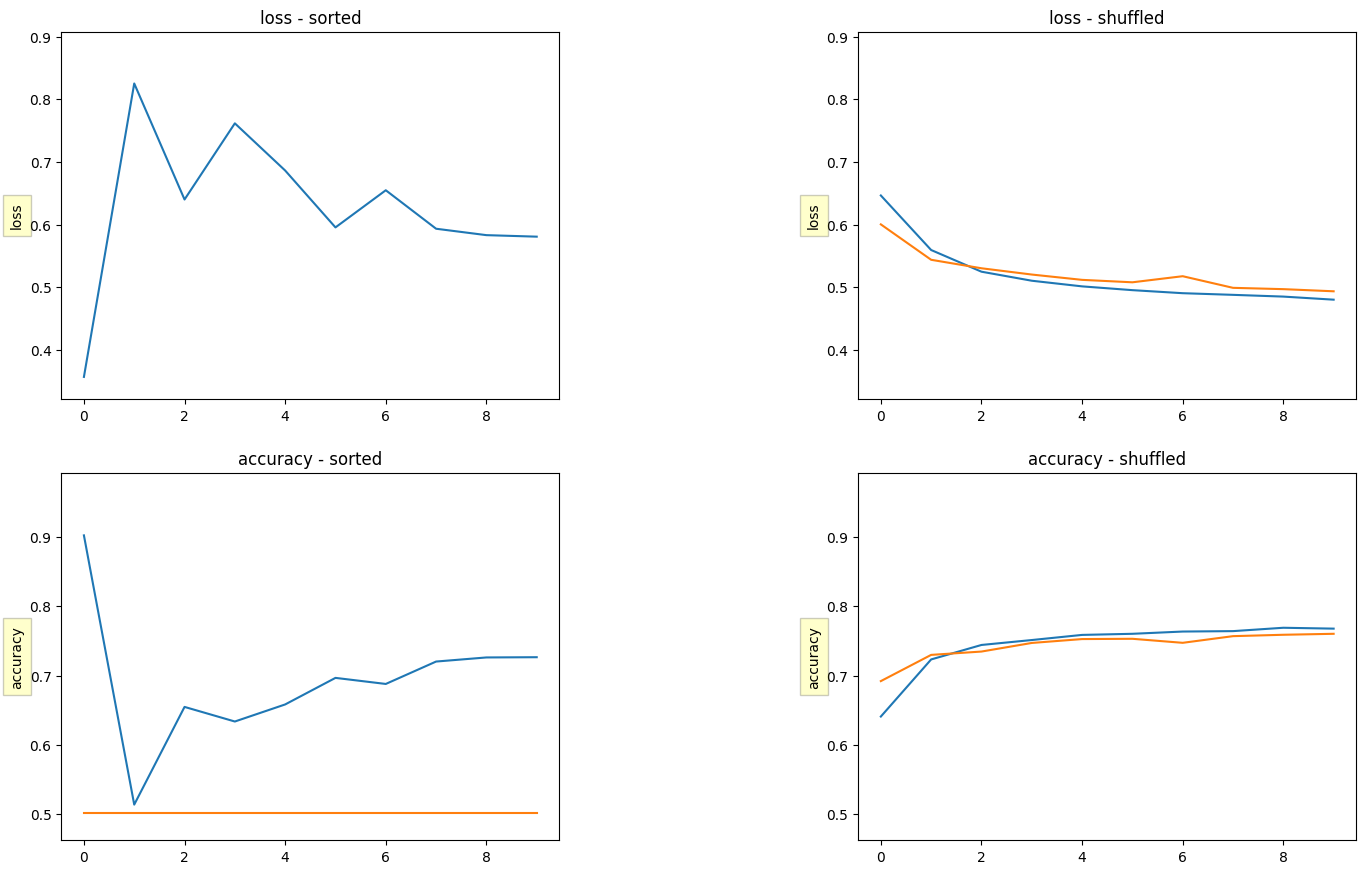

In [29]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          dan_sorted_history,
          dan_shuffled_history,
          model_1_name='sorted',
         model_2_name='shuffled')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

### 2.2 DAN vs Weighted Averaging Models using Attention

#### 2.2.1. Warm-Up: Manual Attention Calculation

**QUESTION:**

2.2.1.a Calculate the context vector for the following query and key/value vectors. You can do this manually, or you can use


```
tf.keras.layers.Attention()
```

2.2.1.b What are the weights for the key/value vectors?


In [30]:
q = [1, 2., 1]

k1 = v1 = [-1, -1, 3.]
k2 = v2 = [1, 2, -5.]

In [38]:

### YOUR CODE HERE ###
output, attention_scores = tf.keras.layers.Attention()([np.array([q]), np.array([k1, k2])], return_attention_scores=True)
print((output, attention_scores))
### END YOUR CODE ###

(<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[ 0. ,  0.5, -1. ]], dtype=float32)>, <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.5, 0.5]], dtype=float32)>)


#### 2.2.2 The 'WAN' Model


Next, we would like to improve our DAN by attempting to train a neural net that learns to put more weight on some words than others. How could we do that? **Attention** is the answer!

Here, we will build a model that you can call "Weighted Averaging Models using Attention". You should construct a network that uses attention to weight the input tokens for a given example.

The core structure is the same as for the DAN network, so remember to re-use the embedding matrix you initialized earlier with word2vec embedding weights.

However, there are obviously some critical changes from the DAN:

1) How do I create a learnable query vector for the attention calculation that is supposed to generate the suitable token probabilities? And what is its size?

2) What are the key vectors for the attention calculation?

3) How does the averaging change?


First, the key vectors should be the incoming word vectors.

The query vector needs to have the size of the word vectors, as it needs to attend to them. A good way to create the query vector is to generate an embedding like vector easily by getting a single row of trained weights from a Dense layer if we pass in a value of one to multiply by that weight matrix in the usual way:


```
wan_query_layer = tf.keras.layers.Dense(embedding_matrix.shape[1])
```

That sounds great... but how do I use this to have a vector available in my calculation? And... make this vector available to all examples in the batch?

What you can use is a 'fake input-like layer' that creates for each incoming batch example a '1', that then the query layer can get applied to.
Assuming that the input layer for your network is **wan_input_layer**, this could be done with

```
wan_one_vector = tf.Variable(tf.ones((1, 1, 1)))
wan_batch_of_ones = tf.tile(wan_one_vector, (tf.shape(wan_input_layer)[0], 1, 1))
```

You could then have the query vector available for each example through:

```
wan_query_vector = wan_query_layer(wan_batch_of_ones)

```

You will see that this structure is essentially the same as what we did for word vectors, except that we had to replace the input layer with our fake layer, as there is no actual input. We will also have **2 outputs** (discussed in a bit.)

How does the averaging change? You should use:

```
tf.keras.layers.Attention()
```

and make sure you consider the proper inputs and outputs for that calculation.

So why 2 outputs, and how do we do that? First off, we need the output that makes the classification, as always. What is the second output? We also would like our model to provide us with the attention weights it calculated. This will tell us which words were considered how much for the context creation.

Can we implement 2 outputs? You need to have a list of the two outputs. But note that you may also want to have a list of 2 cost function and 2 metrics. You can use 'None' both times to account for our new second output, and you can ignore the corresponding values that the model report. (In general, the total loss will be a sum of the individual losses. So one would rather construct a loss that always returns zero for the second loss, but as it is very small we can ignore this here.)

Finally, you may want to reshape the output after the Attention layer, because the Attention layer will still give a sequence of vectors for each example. It will just be a sequence of one weighted average vector for each example. You may want to remove that middle dimension of size one so you just have a single vector for each example. You can do that with layers.Reshape():

```
wan_attention_output = tf.keras.layers.Reshape((wan_attention_output.shape[-1],))(wan_attention_output)
```

In [47]:
def create_wan_model(retrain_embeddings=False,
                     max_sequence_length=MAX_SEQUENCE_LENGTH,
                     hidden_dim=100,
                     dropout=0.3,
                     embedding_initializer='word2vec',
                     learning_rate=0.001):
    """
    Construct the WAN model including the compilation and return it. Parametrize it using the arguments.
    :param retrain_embeddings: boolean, indicating whether the word embeddings are trainable
    :param hidden_dim: dimension of the hidden layer
    :param dropout: dropout applied to the hidden layer

    :returns: the compiled model
    """

    if embedding_initializer == 'word2vec':
        embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix)
    else:
        embeddings_initializer = 'uniform'

    ### YOUR CODE HERE ###
    wan_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=embeddings_initializer,
                                    input_length=max_sequence_length,
                                    trainable=retrain_embeddings)

    wan_input_layer = tf.keras.layers.Input(shape=(max_sequence_length,))
    wan_one_vector = tf.Variable(tf.ones((1, 1, 1)))
    wan_batch_of_ones = tf.tile(wan_one_vector, (tf.shape(wan_input_layer)[0], 1, 1))
    wan_query_layer = tf.keras.layers.Dense(embedding_matrix.shape[1])
    wan_query_vector = wan_query_layer(wan_batch_of_ones)
    wan_embeddings = wan_embedding_layer(wan_input_layer)
    wan_attention = tf.keras.layers.Attention()([wan_query_vector, wan_embeddings], return_attention_scores=True)
    wan_reshape = tf.keras.layers.Reshape((wan_attention[0].shape[-1],))(wan_attention[0])
    wan_hidden = tf.keras.layers.Dense(hidden_dim, activation='relu', name='hidden')(wan_reshape)
    wan_dropout = tf.keras.layers.Dropout(dropout)(wan_hidden)
    wan_classification = tf.keras.layers.Dense(1, activation='sigmoid', name='wan_classification')(wan_dropout)
    wan_model = tf.keras.models.Model(inputs=wan_input_layer, outputs=[wan_classification, wan_attention[1]])
    wan_model.compile(loss=['binary_crossentropy', None],
                      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, name='Adam'),
                      metrics=['accuracy', None])
    ### END YOUR CODE ###

    return wan_model


Now train the model for the same dataset as we did for the DAN model (shuffled data) and save its history in a variable named 'wan_history'.

In [42]:
### YOUR CODE HERE

wan_model = create_wan_model()
wan_history=wan_model.fit(sorted_training_input_ids,
                                          sorted_training_labels,
                                          validation_data=(test_input_ids,test_input_labels),
                                          batch_size=32,
                                          shuffle=True,
                                          epochs=10)
# use wan_history = ... below


### END YOUR CODE

Epoch 1/10
625/625 [==============================] - 5s 5ms/step - loss: 0.5810 - wan_classification_loss: 0.5810 - wan_classification_accuracy: 0.6939 - attention_8_accuracy: 0.0088 - val_loss: 0.5014 - val_wan_classification_loss: 0.5014 - val_wan_classification_accuracy: 0.7590 - val_attention_8_accuracy: 0.0070
Epoch 2/10
625/625 [==============================] - 3s 4ms/step - loss: 0.4898 - wan_classification_loss: 0.4898 - wan_classification_accuracy: 0.7638 - attention_8_accuracy: 0.0079 - val_loss: 0.4800 - val_wan_classification_loss: 0.4800 - val_wan_classification_accuracy: 0.7708 - val_attention_8_accuracy: 0.0062
Epoch 3/10
625/625 [==============================] - 2s 4ms/step - loss: 0.4731 - wan_classification_loss: 0.4731 - wan_classification_accuracy: 0.7742 - attention_8_accuracy: 0.0071 - val_loss: 0.4722 - val_wan_classification_loss: 0.4722 - val_wan_classification_accuracy: 0.7734 - val_attention_8_accuracy: 0.0059
Epoch 4/10
625/625 [==========================

**QUESTION:**

2.2.2.a What is the final validation accuracy that you observed for the wan training after 10 epochs? (Copy and paste the decimal value for the final validation accuracy, e.g. a number like 0.5678 or 0.8765)


Now compare the results of the initial dan_model training and the wan_model training:

KeyError: 'accuracy'

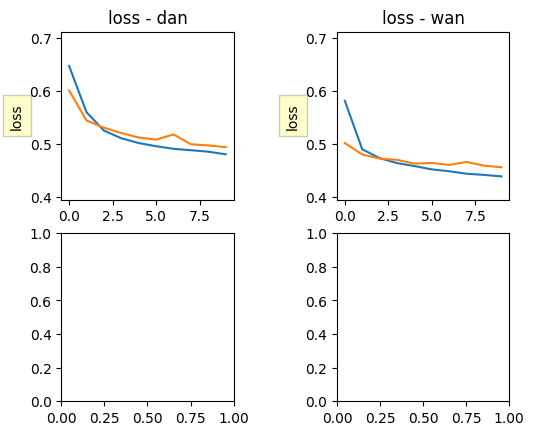

In [43]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          dan_shuffled_history,
          wan_history,
          model_1_name='dan',
         model_2_name='wan')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

Next, let us see for the wan_model which words matter most for the classification prediction and which ones did less so. How can we tell? We can look at the attention weights!

Let's look at the first training example.  We'll need to convert the input_ids back into the associated strings.

In [44]:
train_examples[0].numpy().decode('utf-8')

"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."

The corresponding list of input ids that are suitably formatted, i.e. with sequence length 100, are these:

In [45]:
probe_input_ids = train_input_ids[:1]
probe_input_ids

array([[21531, 25272, 12291,  7427, 37254, 43981,  6891, 12917, 38232,
        16915, 12929, 16182, 43981, 20526, 23487, 43981, 23807, 42958,
        35058, 43981, 19123, 35029, 41270, 29275, 12917, 32597, 20659,
          638, 16915, 43981,   174, 32597, 35058, 39971,  2326,  3636,
        22434, 35029, 43981, 33922, 43981, 21531, 34710, 16908, 12291,
        36880, 28137,  5376, 28038, 43981, 15402, 29155, 18063, 24951,
        17433, 17595,  8856, 14193, 43981, 43248, 17433,  6290, 32597,
         9001, 11511, 43981, 21807, 39168, 43981, 16856, 43981, 43981,
        23245, 43981,  8889,  1331, 43981, 25272, 31976, 19123, 43981,
        18063, 36309, 24099, 16915, 43981, 34710, 36633, 25272, 20413,
        43981, 33458, 14926, 43981, 12139, 12289, 39617, 36633,  9483,
        42958]])

and the first 10 corresponding tokens are:

In [46]:
probe_tokens = [x.decode('utf-8') for x in train_tokens[0].numpy()][:100]
probe_tokens[:10]

['This',
 'was',
 'an',
 'absolutely',
 'terrible',
 'movie.',
 "Don't",
 'be',
 'lured',
 'in']

Using only the first record in the training set, identify the **5 words** with the highest impact and the **5 words** with the lowest impact on the score, i.e., identify the 5 words with the largest and  smallest weights, respectively. (Note that multiple occurences of the same word count separately for the exercise).

HINT: You should create a list of (word/weight) pairs, and then sort by the second argument. Python's '.sort()' function may come in handy.  And make sure you decode the integer ids.

In [106]:
### YOUR CODE HERE

# 'pairs' should be the variable that holds the  token/weight pairs.

# Get attention weights from the WAN model prediction
scores = wan_model.predict(tf.constant([train_input_ids[0]]))[1].reshape(-1)
token_scores = [(token, score) for token, score in zip(probe_tokens, scores)]
token_scores.sort(key=lambda x: x[1], reverse=True)


### END YOUR CODE

print('most important tokens:')
print('\t', pairs[:10])
print('\nleast important tokens:')
print('\t', pairs[-10:])



1/1 [==============================] - 0s 22ms/step
most important tokens:
	 [('worst', 0.12439382), ('terrible', 0.08420442), ('pathetic', 0.05392815), ('pathetic', 0.05392815), ('devoid', 0.037297092), ('ridiculous', 0.032831766), ('nothing', 0.028120765), ('simply', 0.02150264), ('must', 0.020732798), ('disappointed', 0.020155057)]

least important tokens:
	 [('their', 0.0017095639), ('their', 0.0017095639), ('their', 0.0017095639), ('this', 0.0016771855), ('this', 0.0016771855), ('I', 0.0016468309), ('am', 0.001600007), ('her', 0.0015533029), ('The', 0.0014522156), ('the', 0.0012912614)]


 **QUESTION:**

 2.2.2.b List the 5 most important words, with the most important first. (Again, if a word appears twice, you can include it twice.)

 2.2.2.c List the 5 least important words in descending order. (Again, if a word appears twice, note it twice in the answers file.)

### 2.3 Approaches for Training of Embeddings

Rerun the DAN Model in 3 separate configurations:


1.   embedding_initializer = 'word2vec' and retrain_embeddings=False
2.   embedding_initializer = 'word2vec' and retrain_embeddings=True
3.   embedding_initializer = 'uniform' and retrain_embeddings=True


**NOTE:** Train the model with static embeddings for 10 epochs and the ones with trainable embeddings for 3 epochs each.

What do you observe about the effects of initializing and retraining the embedding matrix?



In [51]:
### YOUR CODE HERE
# Create DAN model with default settings
dan1_model = create_dan_model()

# Create DAN model with trainable embeddings
dan2_model = create_dan_model(retrain_embeddings=True)

# Create DAN model with trainable embeddings and uniform initializer
dan3_model = create_dan_model(retrain_embeddings=True, embedding_initializer='random_uniform')


### END YOUR CODE

**QUESTION:**

2.3.a First, what is the final validation accuracy that you just observed for the static model initialized with the word2vec after 10 epochs?  (Copy and paste the decimal value for the final validation accuracy, e.g. a number like 0.5678 or 0.8765)

In [59]:
### YOUR CODE HERE
# Train DAN model (dan1)
dan1_training_history = dan1_model.fit(sorted_training_input_ids,
                                 sorted_training_labels,
                                 validation_data=(test_input_ids, test_input_labels),
                                 batch_size=32,
                                 shuffle=True,
                                 epochs=10)

### END YOUR CODE

Epoch 1/10
625/625 [==============================] - 6s 7ms/step - loss: 0.6408 - accuracy: 0.6493 - val_loss: 0.5897 - val_accuracy: 0.7092
Epoch 2/10
625/625 [==============================] - 4s 7ms/step - loss: 0.5512 - accuracy: 0.7271 - val_loss: 0.5406 - val_accuracy: 0.7322
Epoch 3/10
625/625 [==============================] - 4s 7ms/step - loss: 0.5198 - accuracy: 0.7460 - val_loss: 0.5256 - val_accuracy: 0.7444
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.5076 - accuracy: 0.7549 - val_loss: 0.5178 - val_accuracy: 0.7498
Epoch 5/10
625/625 [==============================] - 4s 6ms/step - loss: 0.4991 - accuracy: 0.7588 - val_loss: 0.5107 - val_accuracy: 0.7550
Epoch 6/10
625/625 [==============================] - 4s 6ms/step - loss: 0.4931 - accuracy: 0.7604 - val_loss: 0.5077 - val_accuracy: 0.7558
Epoch 7/10
625/625 [==============================] - 2s 3ms/step - loss: 0.4885 - accuracy: 0.7645 - val_loss: 0.4999 - val_accuracy: 0.7578
Epoch 

**QUESTION:**


2.3.b What is the final validation accuracy that you observed for the model where you initialized with word2vec vectors but allow them to retrain for 3 epochs? (Copy and paste the decimal value for the final validation accuracy, e.g. a number like 0.5678 or 0.8765)



In [60]:
### YOUR CODE HERE
dan2_training_history = dan2_model.fit(sorted_training_input_ids,
                                 sorted_training_labels,
                                 validation_data=(test_input_ids, test_input_labels),
                                 batch_size=32,
                                 shuffle=True,
                                 epochs=10)

### END YOUR CODE

Epoch 1/10
625/625 [==============================] - 30s 45ms/step - loss: 0.5014 - accuracy: 0.7531 - val_loss: 0.4425 - val_accuracy: 0.7934
Epoch 2/10
625/625 [==============================] - 8s 13ms/step - loss: 0.3214 - accuracy: 0.8670 - val_loss: 0.4567 - val_accuracy: 0.7916
Epoch 3/10
625/625 [==============================] - 5s 8ms/step - loss: 0.2363 - accuracy: 0.9096 - val_loss: 0.5252 - val_accuracy: 0.7786
Epoch 4/10
625/625 [==============================] - 6s 10ms/step - loss: 0.1726 - accuracy: 0.9365 - val_loss: 0.6318 - val_accuracy: 0.7670
Epoch 5/10
625/625 [==============================] - 5s 8ms/step - loss: 0.1226 - accuracy: 0.9547 - val_loss: 0.7506 - val_accuracy: 0.7638
Epoch 6/10
625/625 [==============================] - 5s 8ms/step - loss: 0.0880 - accuracy: 0.9661 - val_loss: 0.9699 - val_accuracy: 0.7590
Epoch 7/10
625/625 [==============================] - 5s 8ms/step - loss: 0.0624 - accuracy: 0.9748 - val_loss: 1.1592 - val_accuracy: 0.7518
Ep

**QUESTION:**

2.3.c What is the final validation accuracy that you observed for the model where you initialized randomly and then trained?  (Copy and paste the decimal value for the final validation accuracy, e.g. a number like 0.5678 or 0.8765)




In [61]:
### YOUR CODE HERE
dan3_training_history = dan3_model.fit(sorted_training_input_ids,
                                 sorted_training_labels,
                                 validation_data=(test_input_ids, test_input_labels),
                                 batch_size=32,
                                 shuffle=True,
                                 epochs=3)

### END YOUR CODE

Epoch 1/3
625/625 [==============================] - 21s 32ms/step - loss: 0.5079 - accuracy: 0.7516 - val_loss: 0.4389 - val_accuracy: 0.7948
Epoch 2/3
625/625 [==============================] - 6s 10ms/step - loss: 0.3203 - accuracy: 0.8662 - val_loss: 0.4551 - val_accuracy: 0.7910
Epoch 3/3
625/625 [==============================] - 5s 7ms/step - loss: 0.2340 - accuracy: 0.9101 - val_loss: 0.5244 - val_accuracy: 0.7714



## 3. BERT-based Classification Models

Now we turn to classification with BERT. We will perform classifications with various models that are based on pre-trained BERT models.


### 3.1. Basics

Let us first explore some basics of BERT.

We've already loaded the pretrained BERT model and tokenizer that we'll use (
'bert-base-cased').

Now, consider this input:

In [63]:
test_input = ['this bank is closed on Sunday', 'the steepest bank of the river is dangerous']

Now apply the BERT tokenizer to tokenize it:

In [64]:
tokenized_input = bert_tokenizer(test_input,
                                 max_length=12,
                                 truncation=True,
                                 padding='max_length',
                                 return_tensors='tf')

tokenized_input

{'input_ids': <tf.Tensor: shape=(2, 12), dtype=int32, numpy=
array([[ 101, 1142, 3085, 1110, 1804, 1113, 3625,  102,    0,    0,    0,
           0],
       [ 101, 1103, 9458, 2556, 3085, 1104, 1103, 2186, 1110, 4249,  102,
           0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(2, 12), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 12), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]], dtype=int32)>}

 **QUESTION:**

 3.1.a  Why do the attention_masks have 4 and 1 zeros, respectively?  Choose the correct one and enter it in the answers file.

  *  For the first example the last four tokens belong to a different segment. For the second one it is only the last token.

  *  For the first example 4 positions are padded while for the second one it is only one.

------


Next, let us look at the BERT outputs for these 2 sentences:

In [65]:
### YOUR CODE HERE

# bert_output = ...

bert_output = bert_model(tokenized_input)

### END YOUR CODE

 **QUESTION:**

 3.1.b How many outputs are there?

 Enter your code below.

In [66]:
### YOUR CODE HERE

#b. -> print it out


print(bert_output)

### END YOUR CODE

TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<tf.Tensor: shape=(2, 12, 768), dtype=float32, numpy=
array([[[ 0.39452153,  0.04198513,  0.06480418, ...,  0.05045479,
          0.22358865,  0.24238198],
        [-0.09458949,  0.06673875, -0.03607525, ...,  0.21925776,
         -0.06967184,  0.7444838 ],
        [ 0.00561068,  0.31316522, -0.179827  , ...,  0.19563268,
         -0.10614735,  0.47773603],
        ...,
        [ 0.22268742, -0.11558606,  0.15854394, ...,  0.30025312,
          0.01634067,  0.51333976],
        [ 0.31638393, -0.10986972,  0.23661843, ...,  0.10924131,
         -0.14340374,  0.32835394],
        [ 0.34834057, -0.10076538,  0.26903224, ...,  0.12707612,
         -0.18430144,  0.26176235]],

       [[ 0.44506398,  0.22264971, -0.0997247 , ..., -0.23736249,
          0.12722515,  0.07778182],
        [ 0.074076  , -0.3180585 , -0.1192469 , ..., -0.06680153,
         -0.3061707 ,  0.4692355 ],
        [ 0.3145811 ,  0.6265878 ,  0.00606324, ..

**QUESTION:**

 3.1.c Which output do we need to use to get token-level embeddings?

 * the first

 * the second

 Put your answer in the answers file.

**QUESTION:**

 3.1.d In the tokenized input, which input_id number (i.e. the vocabulary id) corresponds to 'bank' in the two sentences? ('bert_tokenizer.tokenize()' may come in handy.. and don't forget the CLS token! )


**QUESTION:**

 3.1.e In the array of tokens, which position index number corresponds to 'bank' in the first sentence? ('bert_tokenizer.tokenize()' may come in handy.. and don't forget the CLS token! )

In [67]:
### YOUR CODE HERE

#d/e. -> Look at tokens generated by the bert tokenizer for the first example
tokens = bert_tokenizer.tokenize(test_input[0])
bank_vocab_id = bert_tokenizer.convert_tokens_to_ids('bank')
bank_index = tokens.index('bank')
print("Vocabulary ID for 'bank':", bank_vocab_id)
print("Position index for 'bank' in the tokenized input:", bank_index)

### END YOUR CODE

Vocabulary ID for 'bank': 3085
Position index for 'bank' in the tokenized input: 1


**QUESTION:**

3.1.f Which array position index number corresponds to 'bank' in the second sentence?

In [68]:
### YOUR CODE HERE

#f. -> Look at tokenization for the second example
tokens_second_sentence = bert_tokenizer.tokenize(test_input[1])
bank_index_second_sentence = tokens_second_sentence.index('bank')
print("Position index for 'bank' in the tokenized second sentence:", bank_index_second_sentence)

### END YOUR CODE

Position index for 'bank' in the tokenized second sentence: 3


**QUESTION:**

 3.1.g What is the cosine similarity between the BERT embeddings for the two occurences of 'bank' in the two sentences?

In [75]:
### YOUR CODE HERE

#g.  -> get the vectors and calculate cosine similarity between the two 'bank' BERT embedddings
def calculate_cosine_similarity(vec_a, vec_b):
    dot_product = np.dot(vec_a, vec_b)
    magnitude = np.sqrt(np.dot(vec_a, vec_a) * np.dot(vec_b, vec_b))
    return dot_product / magnitude if magnitude > 0 else 0
def print_cosine_similarities(embeddings):
    for vec1 in embeddings:
        similarity_scores = [f"{calculate_cosine_similarity(vec1, vec2):.4f}" for vec2 in embeddings]
        print('\t'.join(similarity_scores))
embeddings = [bert_output[0][0,2], bert_output[0][1,4]]
print_cosine_similarities(embeddings)

### END YOUR CODE

1.0000	0.7478
0.7478	1.0000


**QUESTION:**

3.1.h How does this relate to the cosine similarity of 'this' (in sentence 1) and the first 'the' (in sentence 2). Compute their cosine similarity.


In [77]:
### YOUR CODE HERE

#h.  -> get the vectors and calculate cosine similarity
def compute_cosine_similarity(vector1, vector2):
    dot_prod = np.dot(vector1, vector2)
    norm_product = np.sqrt(np.dot(vector1, vector1) * np.dot(vector2, vector2))
    if norm_product > 0:
        return dot_prod / norm_product
    else:
        return 0.0
def evaluate_cosine_similarities(vectors):
    for index, vec in enumerate(vectors):
        cos_similarities = [f"{compute_cosine_similarity(vec, other_vec):.4f}" for other_vec in vectors]
        cos_similarities_str = '\t'.join(cos_similarities)
        print(f"Similarities with Vector {index + 1}: {cos_similarities_str}")
this_embedding = bert_output[0][0,1]
the_embedding = bert_output[0][1,1]

evaluate_cosine_similarities([this_embedding, the_embedding])

### END YOUR CODE

Similarities with Vector 1: 1.0000	0.8110
Similarities with Vector 2: 0.8110	1.0000


### 3.2 CLS-Token-based Classification

In the live session we discussed classification with BERT using the pooled token. We now will do the same but extract the [CLS] token output for each example and use that for classification purposes.

Consult the model from the live session and change accordingly. Make sure the BERT model is fully trainable.

**HINT:**
You will want to extract the output of the [CLS] token from the BERT output similarly to what we did above to get the output for 'bank', etc.


In [107]:
def create_bert_cls_model(bert_base_model,
                          max_sequence_length=MAX_SEQUENCE_LENGTH,
                          hidden_size = 100,
                          dropout=0.3,
                          learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the CLS Token output for classification purposes.
    """

    ### YOUR CODE HERE

    bert_base_model.trainable = True

    ids_input = Input((MAX_SEQUENCE_LENGTH,), dtype='int64', name='layer_input_ids')
    ids_token_type = Input((MAX_SEQUENCE_LENGTH,), dtype='int64', name='layer_token_type_ids')
    mask_attention = Input((MAX_SEQUENCE_LENGTH,), dtype='int64', name='layer_attention_mask')

    model_inputs = {
        'input_ids': ids_input,
        'token_type_ids': ids_token_type,
        'attention_mask': mask_attention
    }
    output_from_bert = bert_base_model(model_inputs)

    token_cls = output_from_bert[0][:, 0, :]

    layer_hidden_dense = Dense(hidden_size, activation='relu', name='layer_dense_hidden')(token_cls)
    layer_dropout = Dropout(dropout)(layer_hidden_dense)

    layer_output_class = Dense(1, activation='sigmoid', name='layer_output_class')(layer_dropout)

    model_for_classification = Model(inputs=model_inputs.values(), outputs=layer_output_class)

    model_for_classification.compile(optimizer=Adam(learning_rate),
                                     loss=BinaryCrossentropy(from_logits=False),
                                     metrics=['accuracy'])

    ### END YOUR CODE

    return classification_model

Now create the model and train for 2 epochs. Use batch size 8 and the appropriate validation/test set. (We don't make a distinction here between validation and test although we might in other contexts.)


In [108]:
### YOUR CODE HERE
bert_model = TFBertModel.from_pretrained('bert-base-cased')
bert_cls_model=create_bert_cls_model(bert_model)
bert_cls_history=bert_cls_model.fit(
    bert_train_inputs,
    bert_train_labels,
    validation_data=(bert_test_inputs, bert_test_labels),
    batch_size=8,
    epochs=2
    )
### END YOUR CODE

Epoch 1/2


2500/2500 [==============================] - 535s 200ms/step - loss: 0.4330 - accuracy: 0.8009 - val_loss: 0.3611 - val_accuracy: 0.8392
Epoch 2/2
2500/2500 [==============================] - 497s 199ms/step - loss: 0.2844 - accuracy: 0.8831 - val_loss: 0.3918 - val_accuracy: 0.8428


 **QUESTION:**

 3.2.a What is the final validation accuracy that you observed for the [CLS]-classification model after training for 2 epochs? (Copy and paste the decimal value for the final validation accuracy, e.g. a number like 0.5678 or 0.8765)




### 3.3 Classification by Averaging the BERT outputs

Instead of using only the output vector for the [CLS] token, we will now average the output vectors from BERT for all of the tokens in the full sequence.

**HINT:**
You will want to get the full sequence of token output vectors from the BERT model and then apply an average across the tokens. You may want to use:

```
tf.math.reduce_mean()
```
but you can also do it in other ways.



In [101]:
def create_bert_avg_model(bert_a_model,
                          max_sequence_length=MAX_SEQUENCE_LENGTH,
                          hidden_size = 100,
                          dropout=0.3,
                          learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the average of the BERT output tokens
    """

    ### YOUR CODE HERE
    """
    Build a simple classification model with BERT. Use the average of the BERT output tokens
    """

    ### YOUR CODE HERE
    bert_a_model.trainable = True

    id_input = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
    type_id_input = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids_layer')
    mask_input = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')

    inputs_for_bert = dict(input_ids=id_input, token_type_ids=type_id_input, attention_mask=mask_input)
    output_from_bert = bert_a_model(inputs_for_bert)

    mean_token_output = tf.math.reduce_mean(output_from_bert[0], axis=1)

    dense_hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(mean_token_output)

    dropout_layer = tf.keras.layers.Dropout(dropout)(dense_hidden)

    output_classifier = tf.keras.layers.Dense(1, activation='sigmoid', name='classification_layer')(dropout_layer)

    model_classifier = tf.keras.Model(inputs=[id_input, type_id_input, mask_input], outputs=output_classifier)

    model_classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                             loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                             metrics=['accuracy'])
    ### END YOUR CODE

    return classification_model

Now create the model and train for 2 epochs. Use batch size 8 and the appropriate validation/test set. (We again don't make a distinction here.)  Remember that all layers of the BERT model should be trainable.

In [102]:
### YOUR CODE HERE
bert_model = TFBertModel.from_pretrained('bert-base-cased')
bert_a_model=create_bert_avg_model(bert_model)
bert_a_history=bert_a_model.fit(
    bert_train_inputs,
    bert_train_labels,
    validation_data=(bert_test_inputs, bert_test_labels),
    batch_size=8,
    epochs=2
    )

### END YOUR CODE

Epoch 1/2


2500/2500 [==============================] - 527s 197ms/step - loss: 0.4160 - accuracy: 0.8076 - val_loss: 0.3784 - val_accuracy: 0.8268
Epoch 2/2
2500/2500 [==============================] - 489s 195ms/step - loss: 0.2738 - accuracy: 0.8879 - val_loss: 0.3665 - val_accuracy: 0.8438


 **QUESTION:**

 3.3.a What is the final validation accuracy that you observed for the BERT-averaging-classification model after training for 2 epochs? (Copy and paste the decimal value for the final validation accuracy, e.g. a number like 0.5678 or 0.8765)




### 3.4 Adding a CNN on top of BERT

Can we also combine advanced architectures? Absolutely! In the end we are dealing with tensors and it does not matter whether they are coming from static word2vec embeddings or context-based BERT embeddings. (Whether we want to is another question, but let's try it here.)


**HINT:**
You should appropriately stitch together the BERT-based components and the CNN components from the lesson notebook. Remember that BERT provides a sequence of contextualized token embeddings as its main output, and a CNN takes a sequence of vectors as input.

Use the provided hyperparameters for CNN filter sizes and numbers of filters. Keep the same hyperparameters for the rest of the model, including a dropout layer and dense layer after the CNN, with the provided dropout rate and hidden_size. Again make sure the BERT model is trainable.

In [103]:
def create_bert_cnn_model(bert_cnn_model,
                          max_sequence_length=MAX_SEQUENCE_LENGTH,
                          num_filters = [131, 127, 51, 23, 17],
                          kernel_sizes = [2, 3, 4, 5, 7],
                          dropout = 0.3,
                          hidden_size = 275, #100
                          learning_rate=0.00005):
    """
    Build a  classification model with BERT, where you apply CNN layers  to the BERT output
    """

    ### YOUR CODE HERE

    bert_cnn_model.trainable = True

    ids_input = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64', name='layer_input_ids')
    ids_token_type = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64', name='layer_token_type_ids')
    mask_attention = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64', name='layer_attention_mask')

    inputs_bert = {
        'input_ids': ids_input,
        'token_type_ids': ids_token_type,
        'attention_mask': mask_attention
    }

    output_bert = bert_cnn_model(inputs_bert)

    convolutional_layers = []

    for kernel_size, filter_count in zip(kernel_sizes, num_filters):
        conv = tf.keras.layers.Conv1D(filters=filter_count, kernel_size=kernel_size, activation='relu')(output_bert[0])
        pooled_conv = tf.keras.layers.GlobalMaxPooling1D()(conv)
        convolutional_layers.append(pooled_conv)

    concatenated_conv_layers = tf.keras.layers.concatenate(convolutional_layers, axis=-1)

    dropout_after_conv = tf.keras.layers.Dropout(dropout_rate)(concatenated_conv_layers)

    dense_hidden = tf.keras.layers.Dense(units=hidden_units, activation='relu', name='dense_hidden_layer')(dropout_after_conv)

    output_dense = tf.keras.layers.Dense(units=1, activation='sigmoid', name='output_dense_layer')(dense_hidden)

    model_bert_cnn = tf.keras.Model(inputs=list(inputs_bert.values()), outputs=output_dense)

    model_bert_cnn.compile(optimizer=tf.keras.optimizers.Adam(rate_learning),
                           loss='binary_crossentropy',
                           metrics=['accuracy'])


    ### END YOUR CODE

    return classification_model

Train this model for 2 epochs as well with mini-batch size of 8:

In [104]:
### YOUR CODE HERE
bert_model = TFBertModel.from_pretrained('bert-base-cased')
bert_cnn_model=create_bert_cnn_model(bert_model)
bert_cnn_history=bert_cnn_model.fit(
    bert_train_inputs,
    bert_train_labels,
    validation_data=(bert_test_inputs, bert_test_labels),
    batch_size=8,
    epochs=2
    )

### END YOUR CODE

Epoch 1/2


2500/2500 [==============================] - 547s 203ms/step - loss: 0.4376 - accuracy: 0.7954 - val_loss: 0.3675 - val_accuracy: 0.8360
Epoch 2/2
2500/2500 [==============================] - 508s 203ms/step - loss: 0.3011 - accuracy: 0.8771 - val_loss: 0.3904 - val_accuracy: 0.8350


 **QUESTION:**

3.4.a What is the final validation accuracy that you observed for the BERT-CNN-classification model after 2 epochs?  (Copy and paste the decimal value for the final validation accuracy, e.g. a number like 0.5678 or 0.8765)


# That's It!
## Congratulations... You are done!
## We hope you learned a ton!